## Access to the DB

### SQLite

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine, MetaData
from sqlalchemy.orm import sessionmaker
import pandas as pd

# the following example will depend on a sqlite db
sqlfile="../churn.db"
engine = create_engine(f"sqlite:///{sqlfile}")
session = sessionmaker(bind=engine)()

from churnmodels.schema import Observation,ActiveWeek, ActivePeriod, Account, Metric, MetricName, Subscription, Event, EventType


### PostGres

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd

from churnmodels.schema import get_schema, get_db_uri

options = {"user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }

if True:
    # tables is a (dynamical) module containg Wrapper classes for our data base
    T=get_schema(options)

    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    engine.dialect.has_schema(engine, options["schema"]) 
    session = sessionmaker(bind=engine)()

    # ..how to bring all tables in T to the global namespace
    for tbl in T.__dict__.keys():
        if not tbl[0].isupper():
            continue
        exec(f"{tbl} = T.{tbl}")


In [8]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy import func, or_
import pandas as pd
import sqlparse

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

def pretty_sql(q1):
    # debug: looking at the SQL pretty printed
    text1=str(q1.statement.compile(engine, compile_kwargs={"literal_binds": True}))
    text2=sqlparse.format(text1, reindent=True, keyword_case='upper')
    return text2
    #print(text2)

#d_start_date = "2020-01-01"
#d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

metric_period=7
d_obs_start = "2020-02-09"
d_obs_end = "2020-05-10"


In [5]:
from sqlalchemy import func
if session.bind.dialect.name == "sqlite":
    # sqlite problematic when computing days
    to_days = lambda some_date: func.julianday(some_date)
else:
    # dummy func because of sqlite
    to_days = lambda some_date: some_date


## cohort plot (§5.1)

In [68]:
from sqlalchemy import case, func, literal

def get_dataset(d_obs_start, d_end_end, metric_period):
    fields=[
        Metric.account_id,
        Observation.observation_date,
        Observation.is_churn
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Observation, Metric.account_id==Observation.account_id)\
        .filter(
            Metric.metric_time> func.DATE(to_days(Observation.observation_date)-metric_period), 
            Metric.metric_time<= Observation.observation_date)\
        .group_by(Metric.account_id, Metric.metric_time,
                  Observation.observation_date, Observation.is_churn)\
        .order_by(Observation.observation_date, Metric.account_id)

    #print(pretty_sql(qr))
    ddf=pd.read_sql(qr.statement, engine)
    ddf=ddf.set_index("account_id")
    return ddf

def get_active_customers():
    last_metric_time=session.query(func.DATE(func.max(Metric.metric_time))).one()[0] or 0
    last_metric_time=str(last_metric_time) # making a string, let the pretty print work for postgres...

    fields=[
        Metric.account_id,
        func.DATE(last_metric_time).label("last_metric_time"),
    ]
    targets={}
    df_metricnames=pd.read_sql(session.query(MetricName).statement,engine)
    for index, row in df_metricnames.iterrows():
        newfield=func.sum(case([
            (Metric.metric_name_id == row.metric_name_id, Metric.metric_value)
            ], else_=0)).label(row.metric_name)
        fields.append(newfield)

    qr=session.query(*fields)\
        .join(Subscription, Metric.account_id==Subscription.account_id)\
        .filter(
            func.DATE(Metric.metric_time) == last_metric_time, 
            func.DATE(Subscription.start_date) <= last_metric_time, 
            or_(func.DATE(Subscription.end_date) >= last_metric_time, Subscription.end_date==None)
            )\
        .group_by(Metric.account_id, "last_metric_time")\
        .order_by(Metric.account_id)

    #print(pretty_sql(qr))
    ddf=pd.read_sql(qr.statement, engine)
    return ddf


# retrieving the metric pivot directly from the DB (not from a csv)
# see SQL in $4.5 dataset
dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
active_customers=get_active_customers()
#print(dataset)


<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

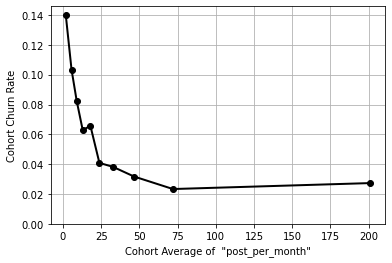

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def cohort_plot(churn_data, metric_to_plot='',ncohort=10):
    groups = pd.qcut(churn_data[metric_to_plot], ncohort, duplicates='drop')
    cohort_means = churn_data.groupby(groups)[metric_to_plot].mean()
    cohort_churns = churn_data.groupby(groups)['is_churn'].mean()
    plot_frame = pd.DataFrame({metric_to_plot: cohort_means.values, 'churn_rate': cohort_churns.values})
    plt.figure(figsize=(6, 4))
    plt.plot(metric_to_plot, 'churn_rate', data=plot_frame,marker='o', color='black', linewidth=2, label=metric_to_plot)
    plt.xlabel('Cohort Average of  "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate')
    plt.grid()
    plt.gca().set_ylim(bottom=0)
    return plt


metric_to_plot="post_per_month"
churn_data=get_dataset(d_obs_start, d_obs_end, metric_period)
cohort_plot(dataset, metric_to_plot)

## dataset statistics (§5.2)

In [61]:
def dataset_stats(churn_data):
    if 'is_churn' in churn_data:
        churn_data['is_churn']=churn_data['is_churn'].astype(float)

    summary = churn_data.describe()
    summary = summary.transpose()
    #print(churn_data)

    summary['skew'] = churn_data.skew()
    summary['1%'] = churn_data.quantile(q=0.01)
    summary['99%'] = churn_data.quantile(q=0.99)
    summary['nonzero'] = churn_data.astype(bool).sum(axis=0) / churn_data.shape[0]

    summary = summary[ ['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max'] ]
    summary.columns = summary.columns.str.replace("%", "pct")
    return summary


dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
summary=dataset_stats(dataset)
print(summary)


                       count   nonzero       mean         std       skew  \
is_churn             12642.0  0.062095   0.062095    0.241337   3.629572   
post_per_month       12642.0  0.985762  41.817592   86.686154  22.382038   
newfriend_per_month  12642.0  0.917023   6.817988    8.295318   3.567486   
like_per_month       12642.0  0.993118  95.872489  190.644593   7.864298   
adview_per_month     12642.0  0.981411  40.229473   76.962260  10.093869   
dislike_per_month    12642.0  0.957681  15.266255   21.011134   4.363458   
unfriend_per_month   12642.0  0.590413   0.890445    0.945190   1.078589   
message_per_month    12642.0  0.980066  56.325265  128.635910  10.774286   
reply_per_month      12642.0  0.906107  21.536545   45.987392   8.608226   
account_tenure       12642.0  1.000000  54.321705   17.782317  -0.372887   

                      min  1pct  25pct  50pct  75pct   99pct     max  
is_churn              0.0   0.0    0.0    0.0    0.0    1.00     1.0  
post_per_month       

## Scoring metric (§5.3)

In [64]:
import numpy as np

def metric_scores(churn_data, stats, skew_thresh=4.0):
    data_scores = churn_data.copy()
    data_scores=data_scores.drop(['is_churn'],axis=1)

    stats=stats.drop('is_churn')
    skewed_columns=(stats['skew']>skew_thresh) & (stats['min'] >= 0)
    skewed_columns=skewed_columns[skewed_columns]

    for col in skewed_columns.keys():
        data_scores[col]=np.log(1.0+data_scores[col])
        stats.at[col,'mean']=data_scores[col].mean()
        stats.at[col,'std']=data_scores[col].std()

    data_scores=(data_scores-stats['mean'])/stats['std']
    data_scores['is_churn']=churn_data['is_churn'].astype('bool')
    return data_scores


dataset=get_dataset(d_obs_start, d_obs_end, metric_period)
stats=dataset_stats(dataset)
scores=metric_scores(dataset, stats)
print(scores)


            account_tenure  adview_per_month  dislike_per_month  \
account_id                                                        
3                -0.299270         -0.127598          -1.097184   
27               -0.299270          1.049643           0.659566   
145              -0.299270          0.636648          -1.483082   
146              -0.299270          1.417648          -0.163688   
151              -0.299270         -0.348528           0.553708   
...                    ...               ...                ...   
11930            -2.211281         -0.651368          -0.611010   
11944            -2.211281         -0.985290           0.298390   
11996            -2.211281         -0.564598           0.496009   
11997            -2.211281          0.467118          -0.611010   
12075            -2.211281         -1.556134          -2.142779   

            like_per_month  message_per_month  newfriend_per_month  \
account_id                                                

## remove invalid (§5.4)

In [67]:
import pandas as pd
import os

def remove_invalid(churn_data, min_valid=None,max_valid=None):
    clean_data = churn_data.copy()

    if min_valid and isinstance(min_valid,dict):
        for metric in min_valid.keys():
            if metric in clean_data.columns.values:
                clean_data=clean_data[clean_data[metric] > min_valid[metric]]
            else:
                print('metric %s is not in the data set %s' % (metric,data_set_path))

    if max_valid and isinstance(max_valid,dict):
        for metric in max_valid.keys():
            if metric in clean_data.columns.values:
                clean_data=clean_data[clean_data[metric] < max_valid[metric]]
            else:
                print('metric %s is not in the data set %s' % (metric,data_set_path))
    return clean_data


clean_data=remove_invalid(dataset)
print(clean_data)


           observation_date  is_churn  post_per_month  newfriend_per_month  \
account_id                                                                   
3                2020-03-01       0.0            15.0                  3.0   
27               2020-03-01       0.0            79.0                  7.0   
145              2020-03-01       0.0           107.0                 10.0   
146              2020-03-01       0.0            75.0                  5.0   
151              2020-03-01       0.0            20.0                  3.0   
...                     ...       ...             ...                  ...   
11930            2020-04-04       0.0            10.0                  1.0   
11944            2020-04-04       1.0             5.0                  3.0   
11996            2020-04-04       0.0            34.0                  7.0   
11997            2020-04-04       0.0            19.0                  1.0   
12075            2020-04-04       0.0             2.0           